# Linear Regression: Retraining and Regularization

In this task, we will see examples of how linear models are overtrained, we will analyze why this happens, and we will find out how to diagnose and control overfitting.

In all cells where a comment with instructions is written, you need to write code that executes these instructions. The remaining cells with code (without comments) just need to be executed. In addition, the assignment requires you to answer questions; Answers must be entered after the highlighted word "__Answer:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

We will work with the __"bikes_rent.csv"__ dataset, in which calendar information and weather conditions characterizing automated bicycle rental points, as well as the number of rentals on that day, are recorded by day. The latter we will predict; thus, we will solve the regression problem.

### Introduction to Data

### Task 1

Load the dataset using the __pandas.read_csv__ function into the __df__ variable. Print the first 5 lines to make sure the data is read correctly:

In [2]:
df = pd.read_csv("bikes_rent.csv")
df.index += 1
print(df.shape)
df.head()

(731, 13)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
1,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
2,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
3,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
4,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
5,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


For each rental day, the following characteristics are known:
* _season_: 1 - spring, 2 - summer, 3 - fall, 4 - winter
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: from 1 to 12
* _holiday_: 0 - no holiday, 1 - holiday
* _weekday_: from 0 to 6
* _workingday_: 0 - non-working day, 1 - working day
* _weathersit_: weather favorableness rating from 1 (clean, clear day) to 4 (rain, fog)
* _temp_: temperature in Celsius
* _atemp_: feels like temperature in Celsius
* _hum_: humidity
* _windspeed(mph)_: wind speed in miles per hour
* _windspeed(ms)_: wind speed in meters per second
* _cnt_: number of rented bicycles (this is the target feature, we will predict it)

So, we have real, binary and nominal (ordinal) features, and all of them can be worked with as real ones. You can also work with nominal characteristics as with real ones, because the order is specified on them. Let's look at the graphs to see how the target feature depends on the others.

Construct graphs of features depending on the number of trips. In other words, you need to build 12 graphs. Each one should show the dependence of the next attribute on the **cnt** variable.

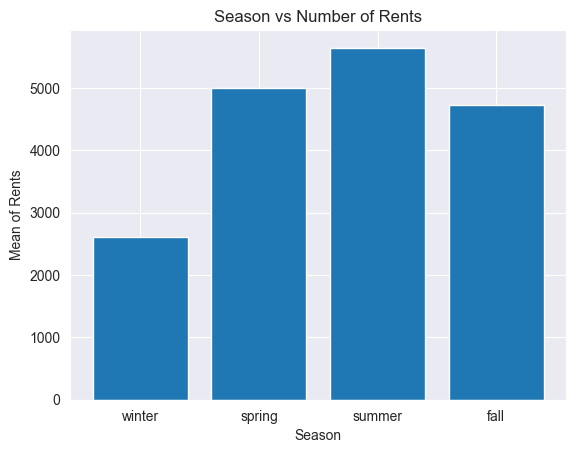

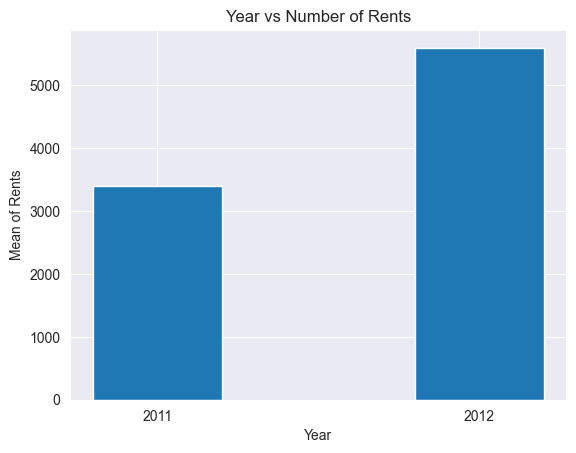

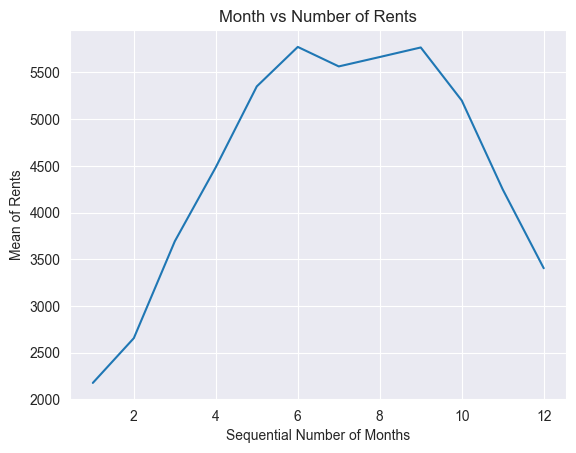

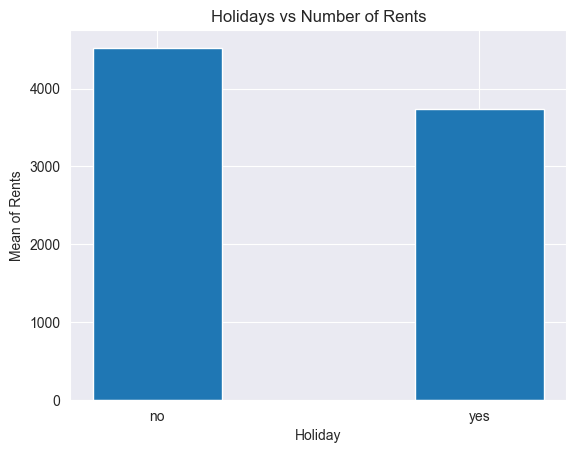

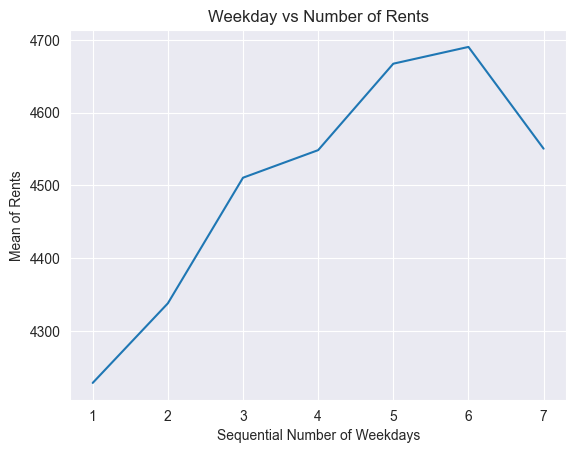

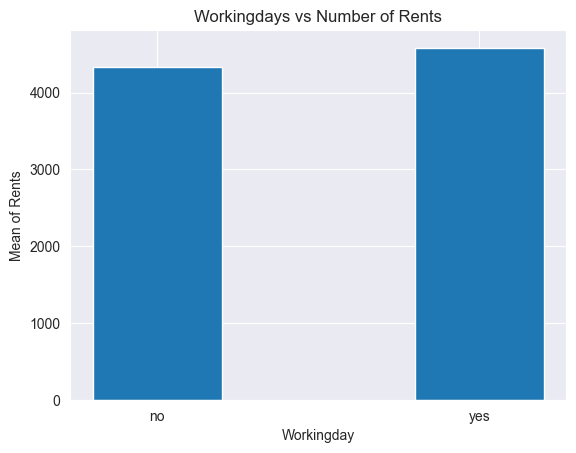

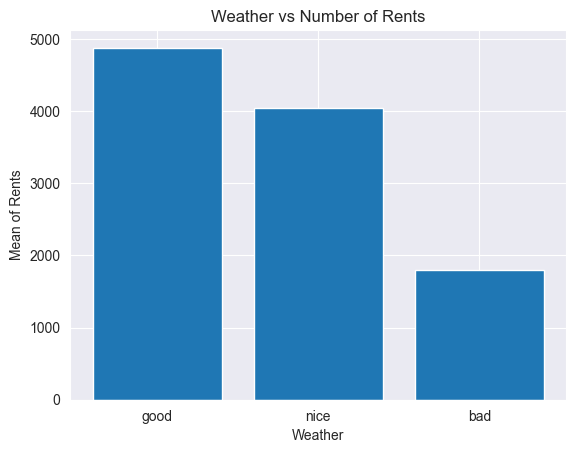

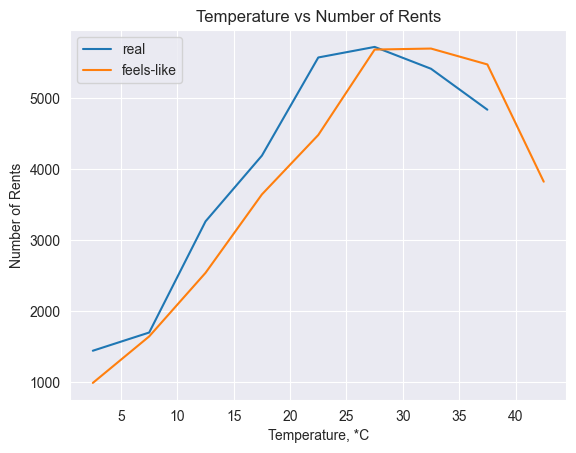

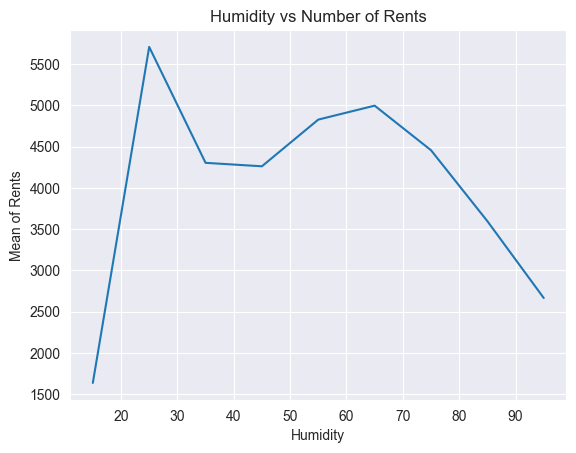

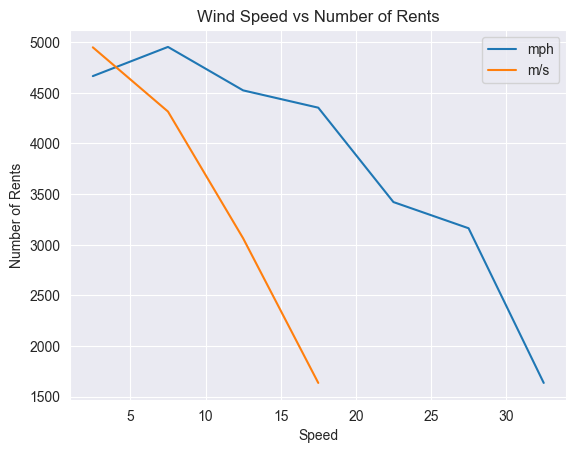

In [74]:
# Season
by_season = df[["season", "cnt"]].groupby("season", sort=True)
df_season = by_season.agg(["mean"])
plt.bar(["winter", "spring", "summer", "fall"], df_season.cnt["mean"])
plt.xlabel("Season")
plt.ylabel("Mean of Rents")
plt.title("Season vs Number of Rents")
plt.show()

# Year
by_year = df[["yr", "cnt"]].groupby("yr", sort=True)
df_year = by_year.agg(["mean"])
plt.bar(["2011", "2012"], df_year.cnt["mean"], 0.4)
plt.xlabel("Year")
plt.ylabel("Mean of Rents")
plt.title("Year vs Number of Rents")
plt.show()

# Month
by_month = df[["mnth", "cnt"]].groupby("mnth", sort=True)
df_month = by_month.agg(["mean"])
plt.plot(df_month)
plt.xlabel("Sequential Number of Months")
plt.ylabel("Mean of Rents")
plt.title("Month vs Number of Rents")
plt.show()

# Holiday
by_holiday = df[["holiday", "cnt"]].groupby("holiday", sort=True)
df_holiday = by_holiday.agg(["mean"])
plt.bar(["no", "yes"], df_holiday.cnt["mean"], 0.4)
plt.xlabel("Holiday")
plt.ylabel("Mean of Rents")
plt.title("Holidays vs Number of Rents")
plt.show()

# Weekday
by_weekday = df[["weekday", "cnt"]].groupby("weekday", sort=True)
df_weekday = by_weekday.agg(["mean"])
df_weekday.index += 1
plt.plot(df_weekday)
plt.xlabel("Sequential Number of Weekdays")
plt.ylabel("Mean of Rents")
plt.title("Weekday vs Number of Rents")
plt.show()

# Working Day
by_workingday = df[["workingday", "cnt"]].groupby("workingday", sort=True)
df_workingday = by_workingday.agg(["mean"])
plt.bar(["no", "yes"], df_workingday.cnt["mean"], 0.4)
plt.xlabel("Workingday")
plt.ylabel("Mean of Rents")
plt.title("Workingdays vs Number of Rents")
plt.show()

# Weather
by_weathersit = df[["weathersit", "cnt"]].groupby("weathersit", sort=True)
df_weathersit = by_weathersit.agg(["mean"])
plt.bar(["good", "nice", "bad"], df_weathersit.cnt["mean"])
plt.xlabel("Weather")
plt.ylabel("Mean of Rents")
plt.title("Weather vs Number of Rents")
plt.show()

# Temperature (real & feels-like)
by_temp = df[["temp", "cnt"]].groupby(pd.cut(df['temp'], [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]), observed=False)
df_temp = by_temp.agg(["mean"]).cnt["mean"].tolist()
by_atemp = df[["atemp", "cnt"]].groupby(pd.cut(df['atemp'], [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]), observed=False)
df_atemp = by_atemp.agg(["mean"]).cnt["mean"].tolist()
temp=[2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5]
plt.plot(temp, df_temp, label="real")
plt.plot(temp, df_atemp, label="feels-like")
plt.xlabel("Temperature, *C")
plt.ylabel("Number of Rents")
plt.title("Temperature vs Number of Rents")
plt.legend()
plt.show()

# Humidity
by_humidity = df[["hum", "cnt"]].groupby(pd.cut(df['hum'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]), observed=False)
df_humidity = by_humidity.agg(["mean"]).cnt["mean"].tolist()
hum=[5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
plt.plot(hum, df_humidity)
plt.xlabel("Humidity")
plt.ylabel("Mean of Rents")
plt.title("Humidity vs Number of Rents")
plt.show()

# Wind speed (mph & m/s)
by_wind_mph = df[["windspeed(mph)", "cnt"]].groupby(pd.cut(df['windspeed(mph)'], [0, 5, 10, 15, 20, 25, 30, 35]), observed=False)
df_wind_mph = by_wind_mph.agg(["mean"]).cnt["mean"].tolist()
by_wind_ms = df[["windspeed(ms)", "cnt"]].groupby(pd.cut(df['windspeed(ms)'], [0, 5, 10, 15, 20, 25, 30, 35]), observed=False)
df_wind_ms = by_wind_ms.agg(["mean"]).cnt["mean"].tolist()
speed=[2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5]
plt.plot(speed, df_wind_mph, label="mph")
plt.plot(speed, df_wind_ms, label="m/s")
plt.xlabel("Speed")
plt.ylabel("Number of Rents")
plt.title("Wind Speed vs Number of Rents")
plt.legend()
plt.show()

__Questions:__
1. What is the nature of the dependence of the number of rentals on the month?
__Answer:__ the dependence is parabolic with a maximum in summer.
2. Indicate one or two characteristics on which the number of rentals most likely depends linearly.
__Answer:__ weekday, weather conditions.

### Task 2

Let's more strictly evaluate the level of linear dependence between the features and the target variable. A good measure of the linear relationship between two vectors is the Pearson correlation. We've had to deal with her before. To calculate it in pandas, you can use the dataframe methods: corr and corrwith.

Calculate the correlations of all features except the last one with the last one using the method `corrwith`.

In [7]:
df.drop("cnt", axis=1).corrwith(df.cnt)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

The sample contains features that correlate with the target, which means the problem can be solved using linear methods.

The graphs show that some features are similar to each other. Therefore, let's also calculate the correlations between real features.

### Task 3

Calculate pairwise correlations between the attributes temp, atemp, hum, windspeed(mph), windspeed(ms) and cnt
using the corr method:

In [75]:
df[["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms)
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000


On the diagonals, as expected, there are units. However, there are two more pairs of highly correlated columns in the matrix: temp and atemp (correlated by nature) and two windspeed (because it is simply a conversion of one unit to another). We will see later that this fact has a negative impact on training a linear model.

Finally, let’s look at the average features (the mean method) to estimate the scale of features and the proportion of 1 for binary features.

### Task 4

Show averages of features

In [76]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

The features have different scales, which means that for further work it is better for us to normalize the object-feature matrix.

### Problem one: collinear features

So, in our data, one feature duplicates another, and there are two more that are very similar. Of course, we could immediately remove duplicates, but let's see how the model would train if we didn't notice this problem.

First, let's carry out scaling, or standardization of features: from each feature, subtract its average and divide by the standard deviation. This can be done using the scale method.

In addition, you need to mix the sample, this is required for cross-validation.

In [77]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [87]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

print(X)
y.head()

[[ 1.354375    0.99863295  1.58866019 ...  0.74372737 -0.21121111
  -0.21121111]
 [-1.34821315 -1.00136893 -1.31026791 ... -1.33538868  1.12681211
   1.12681211]
 [ 1.354375   -1.00136893  1.00887457 ... -0.29551449  0.50349108
   0.50349108]
 ...
 [ 1.354375   -1.00136893  0.71898176 ...  1.55169951 -0.5404777
  -0.5404777 ]
 [-1.34821315  0.99863295 -1.0203751  ... -1.06046036  0.41449871
   0.41449871]
 [-0.44735043 -1.00136893 -0.73048229 ...  1.34385394  0.77643372
   0.77643372]]


704    6606
34     1550
301    3747
457    6041
634    7538
Name: cnt, dtype: int64

Let's train linear regression on our data and look at the feature weights.

In [88]:
from sklearn.linear_model import LinearRegression

### Task 5

Create a linear regressor object, train it on all data, and output the model weights (the weights are stored in the `coef_` variable of the regressor class). You can output pairs (feature name, weight) using the `zip` function built into the python language. The names of the features are stored in the `df.columns` variable.


In [114]:
model = LinearRegression()
model.fit(X, y)

print(model.score(X, y))
print(model.intercept_)
list(zip(df.columns, model.coef_))

0.8005756722890647
4504.354527911491


[('season', 570.8638501320808),
 ('yr', 1021.968374035042),
 ('mnth', -141.30042714888475),
 ('holiday', -86.7589678764022),
 ('weekday', 137.2260243674752),
 ('workingday', 56.39207450989123),
 ('weathersit', -330.22859154239825),
 ('temp', 367.45187644001305),
 ('atemp', 585.5777455406493),
 ('hum', -145.61314651687744),
 ('windspeed(mph)', 12456475364833.373),
 ('windspeed(ms)', -12456475365031.836)]

We see that the weights for linearly dependent features are significantly greater in absolute value than for other features. To understand why this happened, let us recall the analytical formula used to calculate the weights of a linear model in the least squares method:

$$w = (X^TX)^{-1} X^T y$$

If $X$ has collinear (linearly dependent) columns, the matrix $X^TX$ becomes singular and the formula is no longer valid. The more dependent the features, the smaller the determinant of this matrix and the worse the approximation $Xw \approx y$. This situation is called the _multicollinearity problem_.

This did not happen with the pair (temp, atemp) of slightly less correlated variables, but in practice it is always worth carefully monitoring the coefficients for similar features.

In order to solve the problem of multicollinearity, you need to use a regularizer. The $L_1$ or $L_2$ norm of weights multiplied by the regularization coefficient $\alpha$ is added to the optimized functional. In the first case the method is called Lasso, and in the second one - Ridge.

### Task 6
Let's try to train linear models with $L_1$ and $L_2$ regularization, and then compare their weights. Train the Ridge and Lasso regressors with the default parameters and verify that the weight problem is resolved.

Train a linear model with $L_1$-regularization (Lasso class) and output weights

In [112]:
from sklearn.linear_model import Lasso

reg_l1 = Lasso(alpha=1).fit(X, y)

print(reg_l1.score(X, y))
print(reg_l1.intercept_)
list(zip(df.columns, reg_l1.coef_))

0.800239476118262
4504.3488372093025


[('season', 560.2416160308862),
 ('yr', 1019.4634940657196),
 ('mnth', -128.7306270367869),
 ('holiday', -86.15278133371095),
 ('weekday', 137.3478939049631),
 ('workingday', 55.21237064135677),
 ('weathersit', -332.3698569623486),
 ('temp', 376.36323620969597),
 ('atemp', 576.5307935045538),
 ('hum', -144.129155003486),
 ('windspeed(mph)', -197.13968940248404),
 ('windspeed(ms)', -2.8051512738133662e-08)]

Train a linear model with $L_2$-regularization (Ridge class) and output weights

In [113]:
from sklearn.linear_model import Ridge

reg_l2 = Ridge(alpha=1).fit(X, y)

print(reg_l2.score(X, y))
print(reg_l2.intercept_)
list(zip(df.columns, reg_l2.coef_))

0.8002417905136303
4504.3488372093025


[('season', 563.0645722520193),
 ('yr', 1018.9483787875306),
 ('mnth', -131.8733202824786),
 ('holiday', -86.74609799709202),
 ('weekday', 138.00511117871915),
 ('workingday', 55.903110375064806),
 ('weathersit', -332.3497884990724),
 ('temp', 386.4578891919171),
 ('atemp', 566.3470470600581),
 ('hum', -145.07132729867268),
 ('windspeed(mph)', -99.25944108181756),
 ('windspeed(ms)', -99.25944115431525)]

### Task 7

Unlike $L_2$-regularization, $L_1$ resets the weights for some features. Let's observe how the weights change as the regularization coefficient $\alpha$ increases.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [129]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    reg_l1 = Lasso(alpha=alpha).fit(X, y)
    coefs_lasso.append(reg_l1.coef_)

    reg_l2 = Ridge(alpha=alpha).fit(X, y)
    coefs_ridge.append(reg_l2.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
print(coefs_lasso)
print(coefs_ridge)

[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80515127e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29890301e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41660929e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62803010e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.78803150e-08]
 [ 2.

Analyze the dynamics of the weights as the regularization parameter increases:

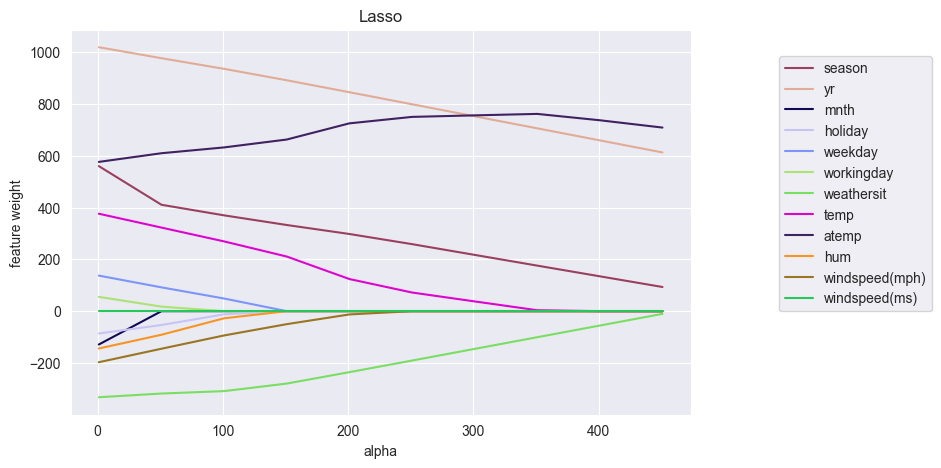

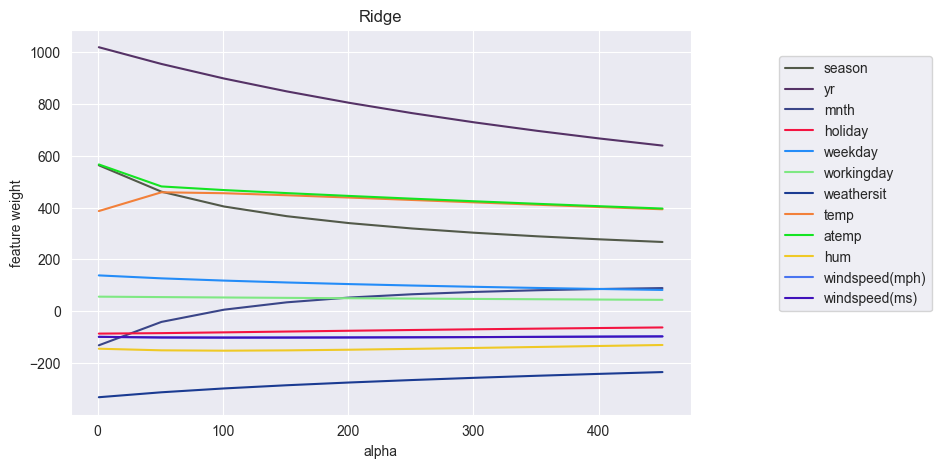

In [134]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Analyze the graphs and answer the following questions.

1. Which regularizer (Ridge or Lasso) reduces weights more aggressively for the same alpha?
__Answer:__ Lasso.
1. What happens to the Lasso weights if alpha is made very large? Explain why this happens.
__Answer:__ Most of them will start heading towards zero because the larger the regularization coefficient, the lower the complexity of the model.
1. Is it possible to say that `Lasso` excludes one of the `windspeed` features for any value of `alpha > 0`? What about Ridge? It is believed that the regularizer excludes a feature if its coefficient is less than $10^{-3}$.
__Answer:__ Yes, Lasso excludes the windspeed and for any value of alpha; No, Ridge never excludes the windspeed.
1. Which regularizer is suitable for selecting uninformative features?
__Answer:__ Lasso.

### Task 8

Next we will work with `Lasso`.

So, we see that when alpha changes, the model selects feature coefficients differently. We need to choose the best alpha.

To do this, firstly, we need a quality metric. We will use as a metric the optimized functionality of the least squares method itself, that is, `Mean Square Error`.

Secondly, you need to understand on what data this metric should be calculated. We cannot select `alpha` based on the MSE value on the training set, because then we will not be able to evaluate how the model will make predictions on data that is new to it. If we choose one division of the sample into training and testing (this is called a holdout), then we will tune in to specific “new” data and can again retrain. Therefore, we will do several sample splits, try different alpha values on each, and then average the MSE. The most convenient way to do such partitions is by cross-validation, that is, divide the sample into $K$ parts, and each time take one of them as a test one, and from the remaining blocks make up a training sample.

Doing cross-validation for regression in sklearn is quite simple: for this there is a special regressor, __LassoCV__, which takes a list of alpha as input and for each of them calculates the MSE for cross-validation. After training (if you leave the cv=3 parameter as default), the regressor will contain the variable __mse\_path\___, a matrix of size len(alpha) x k, k = 3 (the number of blocks in cross-validation), containing the MSE values on the test for the corresponding runs . In addition, the alpha\_ variable will store the selected value of the regularization parameter, and coef\_, traditionally, will store the trained weights corresponding to this alpha_.

Note that the regressor can change the order in which it traverses alphas; For comparison with the MSE matrix, it is better to use the alphas_ regressor variable.

Train the `LassoCV` regressor on all regularization parameters from alpha. Plot the row-averaged `MSE` as a function of `alpha` (use the `create_plot` function for this).

Print the selected `alpha` as well as the feature-coefficient pairs for the trained vector of coefficients.

In [164]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = map(lambda e: e[0], data)
    # y = map(lambda e: e[1], data)
    x = data[0]
    y = data[1]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # plt.grid()
    plt.show()

Alpha = 6
season: 532.0189828413536
yr: 1015.0602226430597
mnth: -100.03952614356652
holiday: -83.2939598752991
weekday: 132.50446549095793
workingday: 51.557085614074055
weathersit: -330.5598567399815
temp: 370.67985503003166
atemp: 581.3969310655002
hum: -140.00740550068855
windspeed(mph): -191.7714084713498
windspeed(ms): -2.6855326892515688e-08


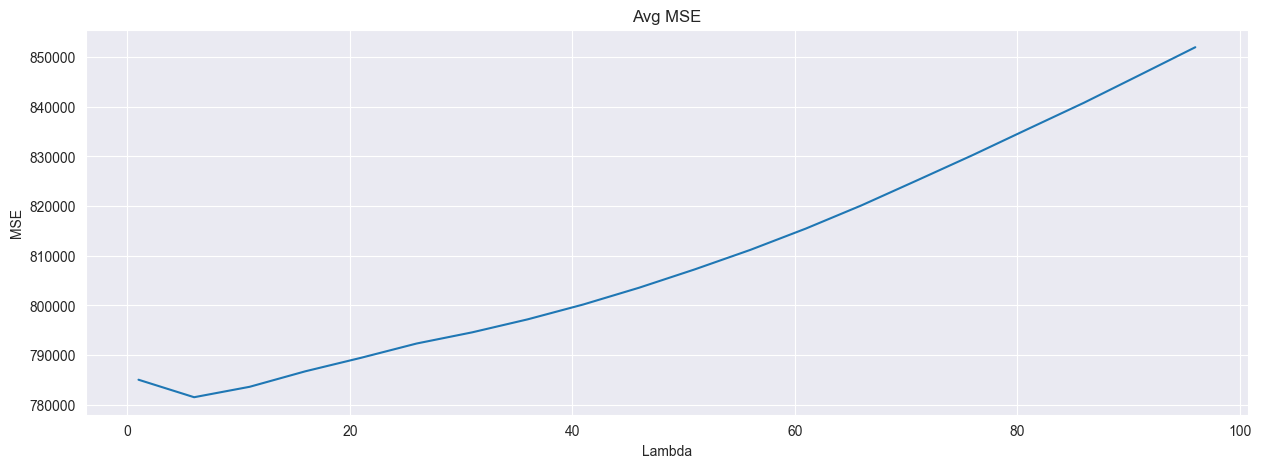

In [166]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)

print(f"Alpha = {regressor.alpha_}")
for i in list(zip(df.columns, regressor.coef_)):
    print(f"{i[0]}: {i[1]}")

data = np.array([regressor.alphas_, regressor.mse_path_.mean(axis=1)])

create_plot(data=data, title="Avg MSE", xlabel="Lambda", ylabel="MSE", figsize=None)

So, we have chosen some regularization parameter. Let's see what alpha we would choose if we divided the sample only once into training and test, that is, consider the MSE trajectories corresponding to individual sampling blocks.

### Task 9

Print the `alpha` values corresponding to the `MSE` minima at each partition (that is, per column).
In three separate plots, visualize the `mse_path_` columns.


Alphas with minimum MSE:
Alpha = 6, MSE = 733725.760405224
Alpha = 1, MSE = 799433.1673691698
Alpha = 51, MSE = 796979.8955193625


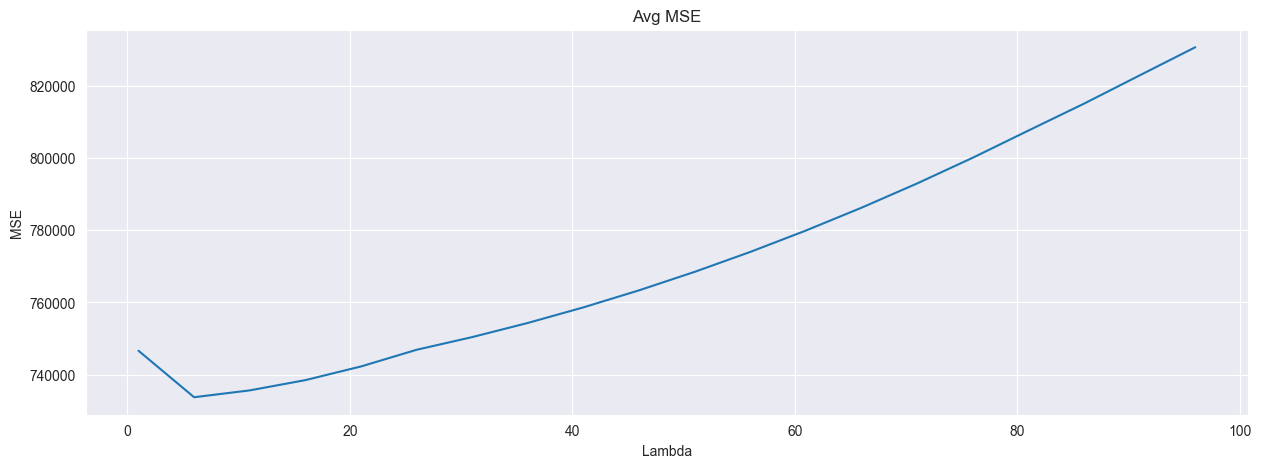

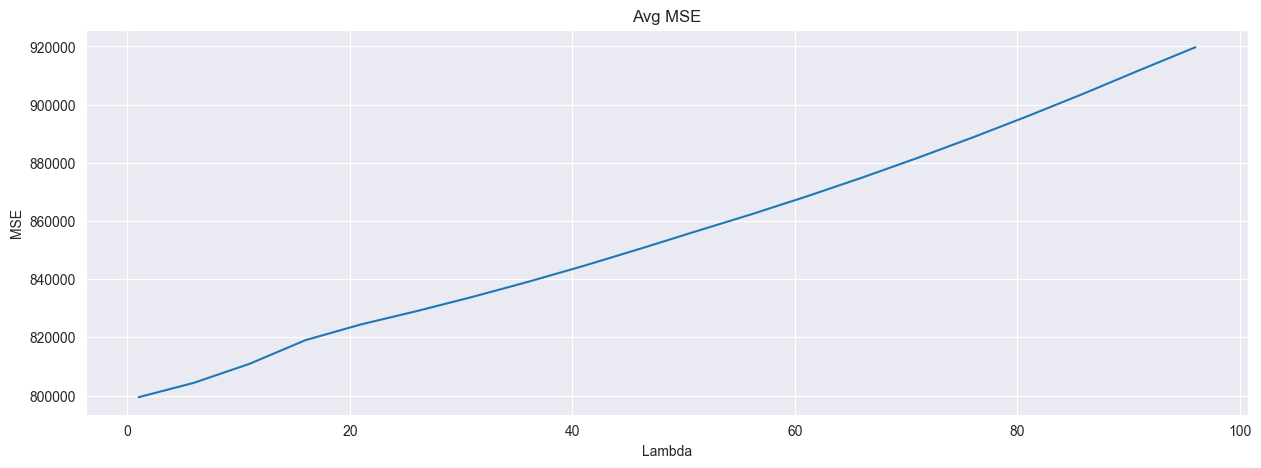

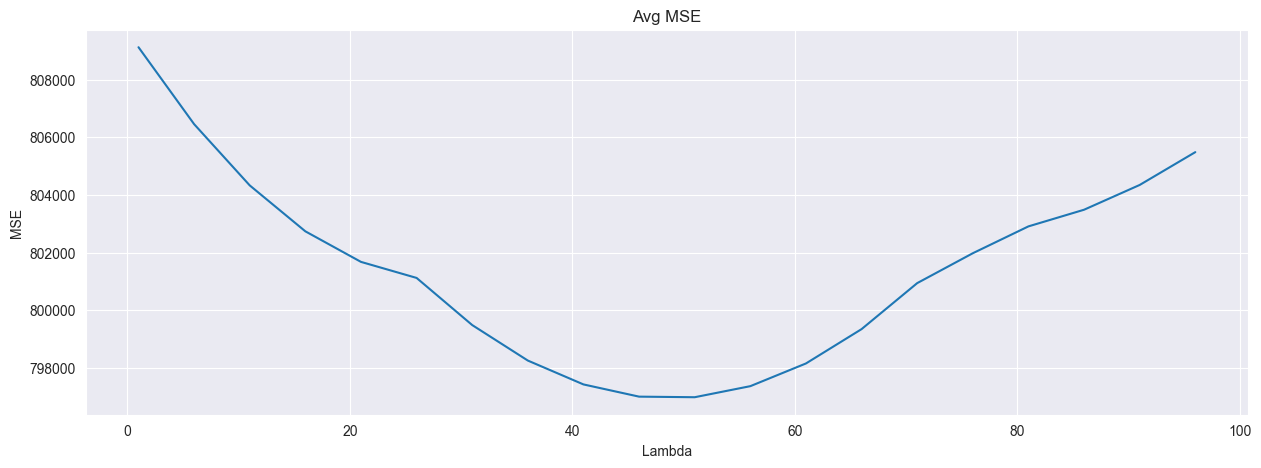

In [209]:
alpha_mse = pd.DataFrame(data=regressor.mse_path_, index=regressor.alphas_).sort_index()

print("Alphas with minimum MSE:")
for i in alpha_mse.columns:
    print(f"Alpha = {alpha_mse.idxmin()[i]}, MSE = {alpha_mse.min()[i]}")

create_plot(data=[alpha_mse.index, alpha_mse[0]], title="Avg MSE", xlabel="Lambda", ylabel="MSE", figsize=None)
create_plot(data=[alpha_mse.index, alpha_mse[1]], title="Avg MSE", xlabel="Lambda", ylabel="MSE", figsize=None)
create_plot(data=[alpha_mse.index, alpha_mse[2]], title="Avg MSE", xlabel="Lambda", ylabel="MSE", figsize=None)

On each partition, the optimal value of `alpha` is different, and it corresponds to a large MSE on other partitions. It turns out that we are tuned to specific training and control samples. When choosing `alpha` for cross-validation, we are choosing something “in the middle” that will give an acceptable metric value across different sample splits.

### Task 10

Finally, as is customary in data analysis, let's interpret the result. Answer the following questions.

#### Question 1

In the last trained model, select 4 features with the largest (positive) coefficients (and write them down), look at the visualizations of the `cnt` dependencies on these features that we drew in the “Getting to know the data” block. Is an increasing linear dependence of `cnt` on these features visible in the graphs? Is it logical to say (from common sense) that the higher the value of these features, the more people will want to take bicycles?

__Answer:__ Year - increasing linear relationship for two years; Feels-Like Temperature - not-linear dependency, increasing up to 27C; Season - not-linear dependency, maximum in Summer; Real Temperature - ot-linear dependency, increasing up to 27C. It's not logical to say that the higher the value of these features, the more people will want to take bicycles (all these features have their optimumns in the midle of their range).

In [259]:
weights = pd.DataFrame(data = regressor.coef_, index = df.drop("cnt", axis=1).columns)
weights.columns = ["weights"]
weights.sort_values("weights", axis=0, inplace=True, ascending=False)
weights.head(4)

,weights
yr,1015.060223
atemp,581.396931
season,532.018983
temp,370.679855


#### Question 2

Select 3 features with the largest absolute negative coefficients (and write them down), look at the corresponding visualizations. Is there a negative linear relationship visible? Is it logical to say that the greater the magnitude of these features, the less people will want to take bicycles?

__Answer:__ Humidity - dependency is not linear, has optimum of bike rentals in range of 25-65%; Windspeed - negative linear relationship; Weather Conditions - negative linear relationship (better weather has lower score). Yes, it's logical ta say that the greater the magnitude of these features, the less people will want to take bicycles

In [260]:
weights.tail(3)

,weights
hum,-140.007406
windspeed(mph),-191.771408
weathersit,-330.559857


#### Question 3

Write down the characteristics with coefficients close to zero (< 1e-3). Why do you think the model excluded them from the model (look at the graphs again)? Is it true that they have no effect on the demand for bicycles?

__Answer:__ Wind Speed in m/s was excluded from the Lasso model because it is the same (collinear) as Wind Speed in mph, just transformed into another unit of measurement.

In [262]:
weights[abs(weights["weights"]) < 0.001]

,weights
windspeed(ms),-2.685533e-08


### Conclusion
So, we looked at how we can monitor the adequacy of a linear model, how to select features, and how to competently, if possible, without adjusting to any specific piece of data, select the regularization coefficient.

It is worth noting that using cross-validation it is convenient to select only a small number of parameters (1, 2, maximum 3), because for each acceptable combination of them we have to train the model several times. This process takes a lot of time, especially if you need to train on large amounts of data.